# **Grafo**

In [ ]:
#  !pip install osmnx


In [ ]:
# !pip install smolagents
# !pip install litellm


In [7]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import heapq as hq
import math
import networkx as nx
from smolagents import CodeAgent, tool, LiteLLMModel
import time

In [8]:
gdf = ox.features_from_place("belo horizonte - MG", {"amenity": True})
print(gdf["amenity"].unique())

['fuel' 'parking' 'hospital' 'bank' 'cafe' 'toilets' 'restaurant'
 'pharmacy' 'recycling' 'bar' 'police' 'nightclub' 'pub' 'fast_food'
 'university' 'cinema' 'taxi' 'car_rental' 'bus_station' 'post_box'
 'telephone' 'place_of_worship' 'theatre' 'school' 'ice_cream' 'car_wash'
 'fire_station' 'post_office' 'love_hotel' 'bench' 'clinic' 'waste_basket'
 'college' 'dentist' 'kindergarten' 'marketplace' 'townhall' 'atm'
 'library' 'bicycle_parking' 'parking_entrance' 'social_facility'
 'compressed_air' 'music_venue' 'arts_centre' 'veterinary' 'studio'
 'language_school' 'General' 'drinking_water' 'courthouse' 'clock'
 'bicycle_rental' 'shelter' 'doctors' 'childcare' 'community_centre'
 'music_school' 'events_venue' 'yes' 'driving_school' 'fountain'
 'waste_disposal' 'bbq' 'social_centre' 'vending_machine' 'dojo'
 'parking_space' 'food_court' 'water_point' 'binoculars'
 'charging_station' 'animal_shelter' 'delivery' 'brothel' 'rental'
 'publisher' 'conference_centre' 'research_institute' 'pu

In [9]:
def Graph():
    G = ox.graph_from_place("Belo Horizonte, MG, Brazil", network_type="walk")

    locais = ["nightclub", "bar"]

    useful_tags = ["name", "addr:street", "contact:phone", "opening_hours"]

    count = {}

    for local in locais:
        features = ox.features_from_place("Belo Horizonte, MG, Brazil", {"amenity": local})
        feature_points = features.representative_point()
        nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)
        count[local] = 0

        for node, feature in zip(nn, features[useful_tags].to_dict(orient="records")):
            feature = {k: v for k, v in feature.items() if pd.notna(v)}
            G.nodes[node].update({local: feature})
            count[local] += 1


    return G, count


In [10]:
def infos(G, count):
  print("O contexto escolhido foi lugares para sair a noite em Belo Horizonte. Para isso, foram selecionadas as amenities 'nightclub' e 'bar'")
  total = 0
  for local, count in count.items():
      print(f"{local.capitalize()}: {count} locais ")
      total += count
  print(f'Total: {total} locais')

  print(f'Número de nós: {len(G.nodes)}')
  print(f'Número de arestas: {len(G.edges)}')

In [42]:
G, count = Graph()
infos(G, count)

O contexto escolhido foi lugares para sair a noite em Belo Horizonte. Para isso, foram selecionadas as amenities 'nightclub' e 'bar'
Nightclub: 20 locais 
Bar: 143 locais 
Total: 163 locais
Número de nós: 47341
Número de arestas: 139578


Grafo da cidade de Belo Horizonte


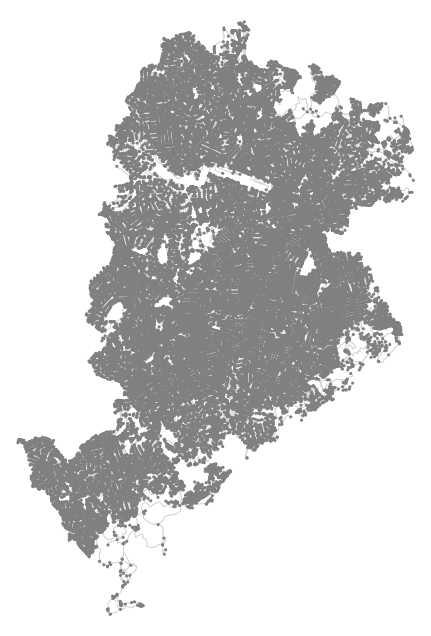

In [12]:
print(f"Grafo da cidade de Belo Horizonte")
fig, ax = ox.plot_graph(G, node_color= "gray", node_size= 5, node_zorder=2, edge_color="lightgray", edge_linewidth=0.5, bgcolor="white",)

Grafo da cidade de Belo Horizonte com as amenities selecionadas


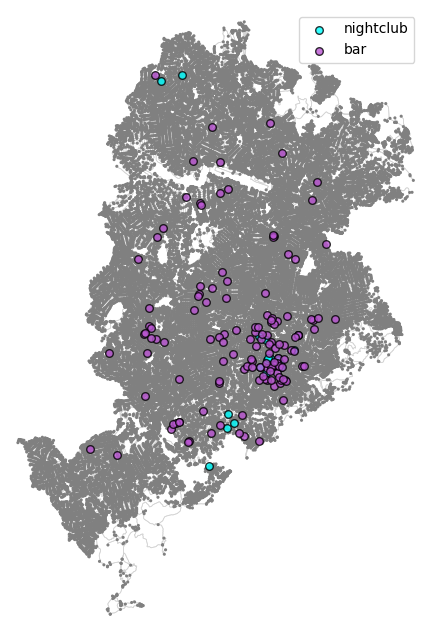

In [13]:
print("Grafo da cidade de Belo Horizonte com as amenities selecionadas")
fig, ax = ox.plot_graph(G, node_color="gray", node_size=5, node_zorder=2, edge_color="lightgray", edge_linewidth=0.5, bgcolor="white", show=False,close=False)

colors = {"nightclub": "aqua", "bar": "mediumorchid"}
sizes = {"nightclub": 30, "bar": 30}

for amenity, color in colors.items():
    xs, ys = [], []
    for node, data in G.nodes(data=True):
        if amenity in data:
            x = data["x"]
            y = data["y"]
            xs.append(x)
            ys.append(y)

    ax.scatter(xs, ys, c=color, s=sizes[amenity], label=amenity, edgecolor="k", alpha=0.8, zorder=3)

plt.legend()
plt.show()


# **Algoritmos de Busca**

### Sem informação: Custo Uniforme (Dijkstra)

In [14]:
def dijkstra(G, inicio, fim):
    distances = {node: float('inf') for node in G.nodes}
    distances[inicio] = 0
    path = {node: None for node in G.nodes}

    queue = [(0, inicio)]

    while queue:
        current_distance, current_node = hq.heappop(queue)

        if current_node == fim:
            break

        for neighbor in G.neighbors(current_node):
            weight = G[current_node][neighbor].get('length', 1)
            new_distance = current_distance + weight

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                path[neighbor] = current_node
                hq.heappush(queue, (new_distance, neighbor))

    route = []
    current = fim
    while current != inicio:
        route.append(current)
        current = path[current]
    route.append(inicio)
    route.reverse()

    return route

In [15]:
def busca(G, nome):
    for node, data in G.nodes(data=True):
        for tipo in ["bar", "nightclub"]:
            if tipo in data:
                items = data[tipo]
                if not isinstance(items, list):
                    items = [items]

                for item in items:
                    if isinstance(item, dict) and item.get("name", "").lower() == nome.lower():
                        return node
    return None

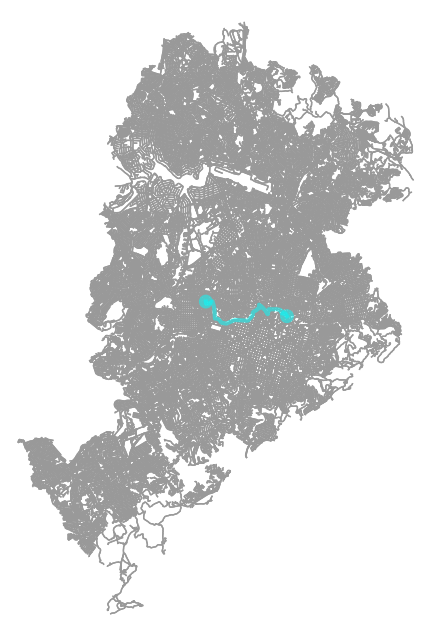

In [16]:
inicio = busca(G, "Mascate")
fim = busca(G, "Mulão")

if inicio is None or fim is None:
    print("Um dos locais não foi encontrado no grafo.")
else:
    rota = dijkstra(G, inicio, fim)
    if rota:
        fig, ax = ox.plot_graph_route(G, rota,route_color='aqua',route_linewidth=3, node_size=0, bgcolor='white')


### A*

In [17]:
def euclidean(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return math.hypot(x2 - x1, y2 - y1)

def Aestrela(G, inicio, fim):
    return nx.astar_path(G, inicio, fim, heuristic= euclidean)


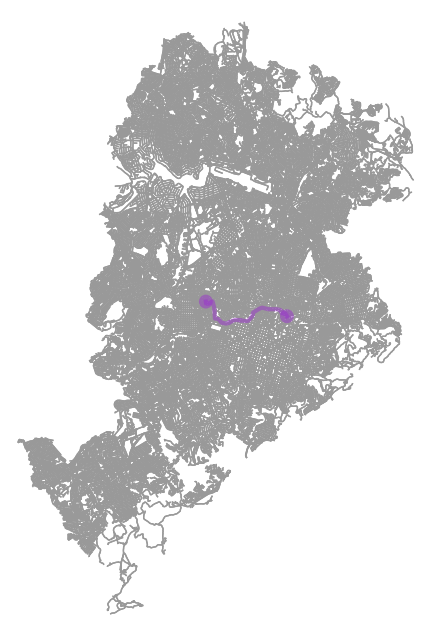

In [18]:
inicio = busca(G, "Mascate")
fim = busca(G, "Mulão")

if inicio is None or fim is None:
    print("Um dos locais não foi encontrado no grafo.")
else:
    rota = Aestrela(G, inicio, fim)
    if rota:
        fig, ax = ox.plot_graph_route(G, rota,route_color='darkorchid',route_linewidth=3, node_size=0, bgcolor='white')


# **Agente**

In [19]:
@tool
def busca_pontos(p1: str, p2: str) -> str:
    """
    Verifica se os pontos p1 e p2 existem no grafo G.

    Args:
        p1 (str): O nome do primeiro ponto a ser buscado no grafo.
        p2 (str): O nome do segundo ponto a ser buscado no grafo.
    """
    inicio = busca(G, p1)
    fim = busca(G, p2)

    if inicio is None and fim is None:
        return f"Os locais '{p1}' e '{p2}' não foram encontrados no grafo."
    elif inicio is None:
        return f"O local '{p1}' não foi encontrado no grafo."
    elif fim is None:
        return f"O local '{p2}' não foi encontrado no grafo."
    else:
        return f"Os pontos '{p1}' e '{p2}' existem no grafo. Pode usar Dijkstra ou A*."

In [20]:
@tool
def chamada_Dijkstra(p1: str, p2: str) -> str:
    """
    Executa o algoritmo de Dijkstra no grafo G entre os pontos p1 e p2.

    Args:
        p1 (str): O nome do ponto de início para o cálculo da rota.
        p2 (str): O nome do ponto de destino para o cálculo da rota.
    """
    inicio = busca(G, p1)
    fim = busca(G, p2)

    if inicio is None or fim is None:
        return "Erro: ponto de origem ou destino inválido."

    rota = dijkstra(G, inicio, fim)
    if not rota:
      return "Não foi possível encontrar uma rota com Dijkstra."

    ruas = []
    atual = None

    for u, v in zip(rota[:-1], rota[1:]):
        aresta = G[u][v][0]
        rua = aresta.get("name", "")

        if not rua:
            continue  # pula ruas sem nome

        if rua != atual:
            if isinstance(rua, list):
                ruas.extend(str(r) for r in rua if r)  # ignora strings vazias
            else:
                ruas.append(str(rua))
            atual = rua

    caminho_str = " -> ".join(ruas) if ruas else "sem nome"
    fig, ax = ox.plot_graph_route(G, rota, route_color='aqua', route_linewidth=3, node_size=0, bgcolor='white')
    return f"Caminho por Dijkstra: {caminho_str} | Custo: {len(rota) - 1}"


In [21]:
@tool
def chamada_Aestrela(p1: str, p2: str) -> str:
    """
    Executa o algoritmo A* no grafo G entre os pontos p1 e p2.

    Args:
        p1 (str): O nome do ponto de início para o cálculo da rota.
        p2 (str): O nome do ponto de destino para o cálculo da rota.
    """
    inicio = busca(G, p1)
    fim = busca(G, p2)

    if inicio is None or fim is None:
        return "Erro: ponto de origem ou destino inválido."

    rota = Aestrela(G, inicio, fim)
    if not rota:
        return "Não foi possível encontrar uma rota com A*."

    ruas = []
    atual = None
    for u, v in zip(rota[:-1], rota[1:]):
        aresta = G[u][v][0]
        rua = aresta.get("name", "")
        if rua != atual:
            if isinstance(rua, list):
                ruas.extend(str(r) for r in rua)
            else:
                ruas.append(str(rua))
            atual = rua

    caminho_str = " -> ".join(ruas) if ruas else "sem nome"
    fig, ax = ox.plot_graph_route(G, rota, route_color='darkorchid', route_linewidth=3, node_size=0, bgcolor='white')
    return f"Caminho por A*: {caminho_str} | Custo: {len(rota) - 1}"

In [22]:
model = LiteLLMModel(
    model_id="openrouter/meta-llama/llama-3.3-8b-instruct:free",
    api_key="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",
    api_base="https://openrouter.ai/api/v1"
)

tools = [busca_pontos ,chamada_Dijkstra, chamada_Aestrela]

agent = CodeAgent(name="AgenteDeRotas", model= model, tools= tools)


# **Prompts**

**Indo de um bar para uma boate usando algoritmo A***

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Jack Rock Bar para Clube Chalezinho usando Aestrela.                                                │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  p1 = "Jack Rock Bar"                                                                                             
  p2 = "Clube Chalezinho"                                                                                          
  rota = chamada_Aestrela(p1, p2)                                                                                  
  print("A rota mais curta é:", rota)                                                                              
                                                                                                                   
  final_answer(rota)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

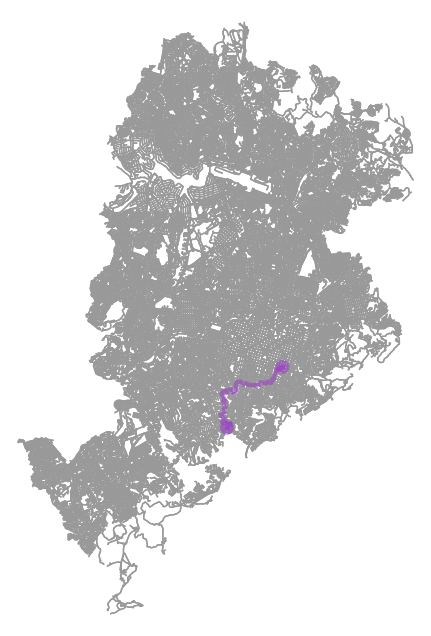

Execution logs:
A rota mais curta é: Caminho por A*: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa Senhora 
do Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua Major Lopes 
-> Rua Cristina -> Rua Lavras -> Rua São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de 
Matos -> Rua Pitangueiras -> Rua Teixeira de Freitas -> Rua Matipó -> Rua Sofia Madalena -> Rua Iraí -> Rua Gentios
-> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos -> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua 
Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11
de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos Lima -> Rua Juiz Achilles Velloso -> Rua Vereador 
Tancredo Guimarães -> Rua Paulo Freire de Araújo ->  -> Avenida Barão Homem de Melo -> Rua Ilacir P da Cunha -> Rua
Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador Amílcar de Castro | Custo: 68

Out - Final answer: Caminho por A*: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa Senhora do
Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua Major Lopes -> 
Rua Cristina -> Rua Lavras -> Rua São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de 
Matos -> Rua Pitangueiras -> Rua Teixeira de Freitas -> Rua Matipó -> Rua Sofia Madalena -> Rua Iraí -> Rua Gentios
-> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos -> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua 
Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11
de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos Lima -> Rua Juiz Achilles Velloso -> Rua Vereador 
Tancredo Guimarães -> Rua Paulo Freire de Araújo ->  -> Avenida Barão Homem de Melo -> Rua Ilacir P da Cunha -> Rua
Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador Amílcar de Castro | Custo: 68

[Step 1: Duration 27.28 seconds| Input tokens: 2,217 | Output tokens: 180]

Caminho por A*: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa Senhora do Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua Major Lopes -> Rua Cristina -> Rua Lavras -> Rua São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de Matos -> Rua Pitangueiras -> Rua Teixeira de Freitas -> Rua Matipó -> Rua Sofia Madalena -> Rua Iraí -> Rua Gentios -> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos -> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11 de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos Lima -> Rua Juiz Achilles Velloso -> Rua Vereador Tancredo Guimarães -> Rua Paulo Freire de Araújo ->  -> Avenida Barão Homem de Melo -> Rua Ilacir P da Cunha -> Rua Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador Amílcar de Castro | Custo: 68


In [ ]:
print(agent.run("Quero ir de Jack Rock Bar para Clube Chalezinho usando Aestrela."))

**Testando o mesmo prompt com o algoritmo de Custo Uniforme**

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Jack Rock Bar para Clube Chalezinho usando Dijkstra.                                                │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  p1 = "Jack Rock Bar"                                                                                             
  p2 = "Clube Chalezinho"                                                                                          
  rota = chamada_Dijkstra(p1, p2)                                                                                  
  print("A rota mais curta é:", rota)                                                                              
                                                                                                                   
  final_answer(rota)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

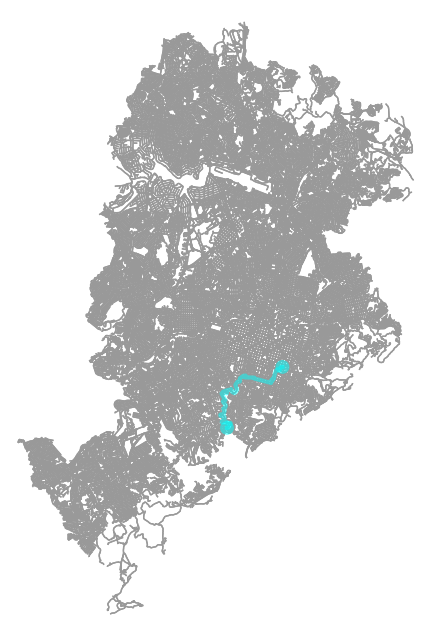

Execution logs:
A rota mais curta é: Caminho por Dijkstra: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa 
Senhora do Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua 
Major Lopes -> Rua Cristina -> Rua Mar de Espanha -> Rua Antônio Dias -> Avenida Prudente de Morais -> Rua Donato 
da Fonseca -> Rua Perdigão Malheiros -> Rua Gentios -> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos 
-> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja 
Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11 de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos 
Lima -> Rua Juiz Achilles Velloso -> Rua Vereador Tancredo Guimarães -> Rua Paulo Freire de Araújo -> Avenida Barão
Homem de Melo -> Rua Ilacir P da Cunha -> Rua Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador
Amílcar de Castro | Custo: 68

Out - Final answer: Caminho por Dijkstra: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa 
Senhora do Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua 
Major Lopes -> Rua Cristina -> Rua Mar de Espanha -> Rua Antônio Dias -> Avenida Prudente de Morais -> Rua Donato 
da Fonseca -> Rua Perdigão Malheiros -> Rua Gentios -> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos 
-> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja 
Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11 de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos 
Lima -> Rua Juiz Achilles Velloso -> Rua Vereador Tancredo Guimarães -> Rua Paulo Freire de Araújo -> Avenida Barão
Homem de Melo -> Rua Ilacir P da Cunha -> Rua Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador
Amílcar de Castro | Custo: 68

[Step 1: Duration 23.98 seconds| Input tokens: 2,215 | Output tokens: 191]

Caminho por Dijkstra: Avenida do Contorno -> Rua Andaluzita -> Rua Outono -> Avenida Nossa Senhora do Carmo -> Passarela Frei Cláudio Van Balen -> Avenida Nossa Senhora do Carmo -> Rua Rio Verde -> Rua Major Lopes -> Rua Cristina -> Rua Mar de Espanha -> Rua Antônio Dias -> Avenida Prudente de Morais -> Rua Donato da Fonseca -> Rua Perdigão Malheiros -> Rua Gentios -> Rua Doutor Ismael de Faria -> Rua Doutor Juvenal dos Santos -> Rua Rotary Club -> Avenida Acesso Bloco 1 -> Rua Gentios -> Rua Alcida Torres -> Rua 5 de Maio -> Avenida Raja Gabaglia -> Rua Radiante -> Rua do Cascalho -> Rua 11 de Dezembro -> Rua Alvino de Paula -> Rua Magnólia Passos Lima -> Rua Juiz Achilles Velloso -> Rua Vereador Tancredo Guimarães -> Rua Paulo Freire de Araújo -> Avenida Barão Homem de Melo -> Rua Ilacir P da Cunha -> Rua Pintor Vicente Abreu -> Rua Eugênio Vidgal Amaro -> Rua Desembargador Amílcar de Castro | Custo: 68


In [23]:
print(agent.run("Quero ir de Jack Rock Bar para Clube Chalezinho usando Dijkstra."))

**Indo de um bar para outro bar usando algoritmo de Custo Uniforme (Dijkstra)**

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Mascate para Bar dos Amigos usando Dijkstra.                                                        │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  p1 = "Mascate"                                                                                                   
  p2 = "Bar dos Amigos"                                                                                            
  if busca_pontos(p1, p2) == "Pontos encontrados":                                                                 
      print("Pontos existem no grafo")                                                                             
  else:                                                                                                            
      print("Pontos não encontrados no grafo")                                                                     
                                                                                                                   
  rotulagem = chamada_Dijkstra(p1, p2)                                                                             
  print("Caminho mais curto:", rotulagem)                                                                          
                                                                                                                   
  final_answer(rotulagem)                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

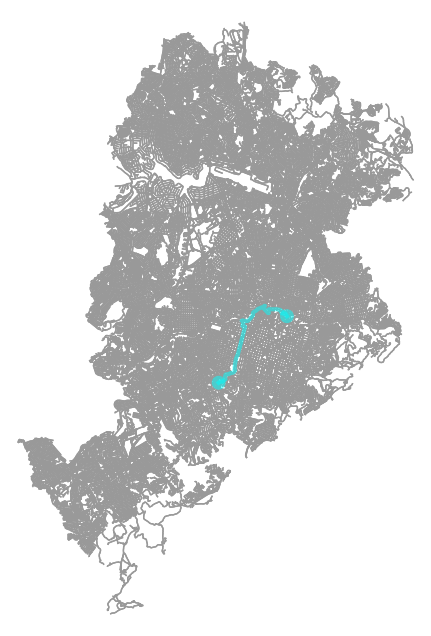

Execution logs:
Pontos não encontrados no grafo
Caminho mais curto: Caminho por Dijkstra: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida 
do Contorno -> Rua Célio de Castro -> Rua Varginha -> Avenida do Contorno -> Viaduto Leste -> Avenida do Contorno 
-> Viaduto Leste -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> Avenida 
Barbacena -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia -> Rua Professor Baroni -> Rua Porto 
Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua Vereda do Paraíso -> Rua Estrada Nova | Custo: 59

Out - Final answer: Caminho por Dijkstra: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida 
do Contorno -> Rua Célio de Castro -> Rua Varginha -> Avenida do Contorno -> Viaduto Leste -> Avenida do Contorno 
-> Viaduto Leste -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> Avenida 
Barbacena -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia -> Rua Professor Baroni -> Rua Porto 
Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua Vereda do Paraíso -> Rua Estrada Nova | Custo: 59

[Step 1: Duration 27.01 seconds| Input tokens: 2,213 | Output tokens: 318]

Caminho por Dijkstra: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida do Contorno -> Rua Célio de Castro -> Rua Varginha -> Avenida do Contorno -> Viaduto Leste -> Avenida do Contorno -> Viaduto Leste -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> Avenida Barbacena -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia -> Rua Professor Baroni -> Rua Porto Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua Vereda do Paraíso -> Rua Estrada Nova | Custo: 59


In [ ]:
print(agent.run("Quero ir de Mascate para Bar dos Amigos usando Dijkstra."))

**Testando o mesmo prompt para o algoritmo A***

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Mascate para Bar dos Amigos usando A*.                                                              │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  p1 = "Mascate"                                                                                                   
  p2 = "Bar dos Amigos"                                                                                            
  rota = chamada_Aestrela(p1, p2)                                                                                  
  print("A rota mais curta é:", rota)                                                                              
                                                                                                                   
  final_answer(rota)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

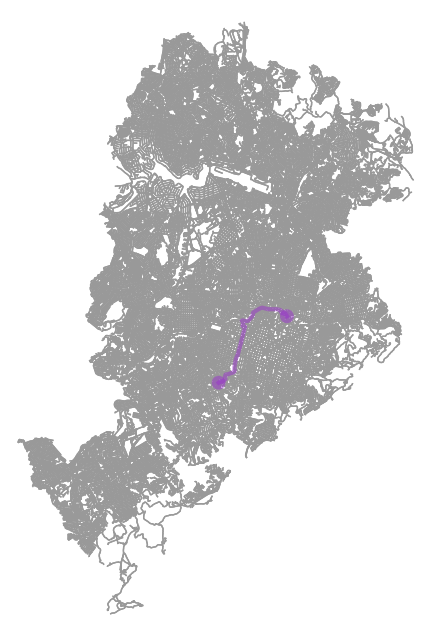

Execution logs:
A rota mais curta é: Caminho por A*: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida do 
Contorno -> Rua Célio de Castro -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> 
Avenida Barbacena ->  -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia ->  -> Avenida Raja 
Gabaglia -> Rua Professor Baroni -> Rua Porto Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua 
Estrada Nova -> Rua Vereda do Paraíso | Custo: 59

Out - Final answer: Caminho por A*: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida do 
Contorno -> Rua Célio de Castro -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> 
Avenida Barbacena ->  -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia ->  -> Avenida Raja 
Gabaglia -> Rua Professor Baroni -> Rua Porto Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua 
Estrada Nova -> Rua Vereda do Paraíso | Custo: 59

[Step 1: Duration 26.64 seconds| Input tokens: 2,212 | Output tokens: 217]

Caminho por A*: Avenida do Contorno -> Rua Teixeira Magalhães -> Rua Itajubá -> Avenida do Contorno -> Rua Célio de Castro -> Avenida do Contorno -> Rua Ouro Preto -> Rua dos Goitacazes -> Rua Araguari -> Avenida Barbacena ->  -> Rua Araguari -> Avenida Álvares Cabral -> Avenida Raja Gabaglia ->  -> Avenida Raja Gabaglia -> Rua Professor Baroni -> Rua Porto Carrero -> Rua Cachoeira de Minas -> Rua Vereda do Paraíso -> Rua Estrada Nova -> Rua Vereda do Paraíso | Custo: 59


In [34]:
print(agent.run("Quero ir de Mascate para Bar dos Amigos usando A*."))

**Testando rota com pontos que não existem no grafo**

In [28]:
print(agent.run("Quero ir de Mascate para Ancho usando A*."))

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Mascate para Ancho usando A*.                                                                       │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  rota = chamada_Aestrela(p1="Mascate", p2="Ancho")                                                                
  print("A rota mais curta de Mascate para Ancho é:", rota)                                                        
                                                                                                                   
  final_answer(rota)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
A rota mais curta de Mascate para Ancho é: Erro: ponto de origem ou destino inválido.

Out - Final answer: Erro: ponto de origem ou destino inválido.

[Step 1: Duration 1.64 seconds| Input tokens: 2,210 | Output tokens: 243]

Erro: ponto de origem ou destino inválido.


**Testando rota sem especificar o algoritmo a ser utilizado**

╭──────────────────────────────────────────── New run - AgenteDeRotas ────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Stop Chopp para Alambique.                                                                          │
│                                                                                                                 │
╰─ LiteLLMModel - openrouter/meta-llama/llama-3.3-8b-instruct:free ───────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  p1 = "Stop Chopp"                                                                                                
  p2 = "Alambique"                                                                                                 
  existence = busca_pontos(p1, p2)                                                                                 
  print("Existência dos pontos no grafo:", existence)                                                              
  if existence:                                                                                                    
      rota = chamada_Dijkstra(p1, p2)                                                                              
      print("Rota de Stop Chopp para Alambique:", rota)                                                            
  else:                                                                                                            
      print("Um dos pontos não existe no grafo.")                                                                  
                                                                                                                   
  final_answer(rota)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

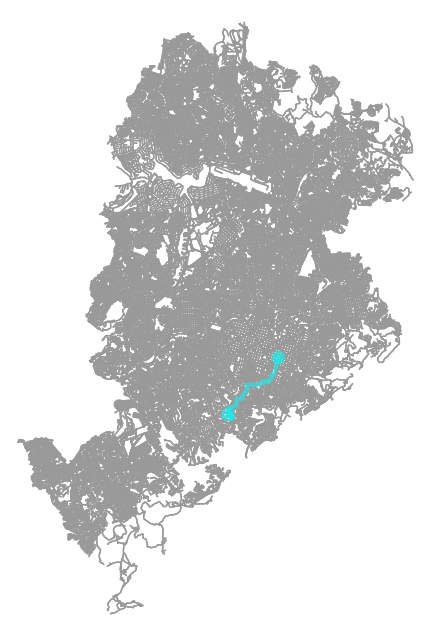

Execution logs:
Existência dos pontos no grafo: Os pontos 'Stop Chopp' e 'Alambique' existem no grafo. Pode usar Dijkstra ou A*.
Rota de Stop Chopp para Alambique: Caminho por Dijkstra: Rua Rio Grande do Norte -> Avenida Nossa Senhora do Carmo 
-> Rua Montes Claros -> Rua Major Lopes -> Rua São Domingos do Prata -> Rua Padre Severino -> Rua Cristina -> Rua 
Viçosa -> Rua São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de Matos -> Rua 
Pitangueiras -> Rua Guilherme de Almeida -> Avenida Prudente de Morais -> Avenida Artur Bernardes -> Rua Iraí -> 
Rua Visconde do Rio das Velhas -> Rua Soares do Couto -> Avenida Artur Bernardes -> Avenida Consul Antônio Cadar ->
Rua Professor José Renault -> Rua Cônsul Robert Levy -> Rua Desembargador Melo Júnior -> Rua Fernando Franca Campos
-> Avenida Professor Silvio de Vasconcellos -> Rua Deputado Milton Sales -> Rua Ivon Magalhães Pinto -> Avenida 
Raja Gabaglia | Custo: 60

Out - Final answer: Caminho por Dijkstra: Rua Rio Grande do Norte -> Avenida Nossa Senhora do Carmo -> Rua Montes 
Claros -> Rua Major Lopes -> Rua São Domingos do Prata -> Rua Padre Severino -> Rua Cristina -> Rua Viçosa -> Rua 
São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de Matos -> Rua Pitangueiras -> Rua 
Guilherme de Almeida -> Avenida Prudente de Morais -> Avenida Artur Bernardes -> Rua Iraí -> Rua Visconde do Rio 
das Velhas -> Rua Soares do Couto -> Avenida Artur Bernardes -> Avenida Consul Antônio Cadar -> Rua Professor José 
Renault -> Rua Cônsul Robert Levy -> Rua Desembargador Melo Júnior -> Rua Fernando Franca Campos -> Avenida 
Professor Silvio de Vasconcellos -> Rua Deputado Milton Sales -> Rua Ivon Magalhães Pinto -> Avenida Raja Gabaglia 
| Custo: 60

[Step 1: Duration 25.47 seconds| Input tokens: 2,209 | Output tokens: 283]

Caminho por Dijkstra: Rua Rio Grande do Norte -> Avenida Nossa Senhora do Carmo -> Rua Montes Claros -> Rua Major Lopes -> Rua São Domingos do Prata -> Rua Padre Severino -> Rua Cristina -> Rua Viçosa -> Rua São João Evangelista -> Rua Santo Antônio do Monte -> Rua Professor Aníbal de Matos -> Rua Pitangueiras -> Rua Guilherme de Almeida -> Avenida Prudente de Morais -> Avenida Artur Bernardes -> Rua Iraí -> Rua Visconde do Rio das Velhas -> Rua Soares do Couto -> Avenida Artur Bernardes -> Avenida Consul Antônio Cadar -> Rua Professor José Renault -> Rua Cônsul Robert Levy -> Rua Desembargador Melo Júnior -> Rua Fernando Franca Campos -> Avenida Professor Silvio de Vasconcellos -> Rua Deputado Milton Sales -> Rua Ivon Magalhães Pinto -> Avenida Raja Gabaglia | Custo: 60


In [32]:
print(agent.run("Quero ir de Stop Chopp para Alambique."))

# **Opções de locais para testar novos prompts**

**Para testar mais prompts basta seguir os modelos acima e escolher os locais listados abaixo:**

**Nightclub:**
- Alambique
- Lord Pub
- Clube Chalezinho
- Flamengo                                                              
- Amsterdam Pub
- IMPERIAL EVENTOSBH
- Skorpius New
- Lapa Multishow
- Cheio de Graça
- Mary in Hell


**Bar:**

- Stop Chopp
- Chxico do Churrasco da Rua Albita
- Bar do Hugo
- Sátira
- Bar do Galo
- Bolão 2
- D'Gust Burguer
- Krug Bier
- Zavino
- Chic Tácio
- Bar do Zezé
- Bar e Restaurante Seu Braz 1949
- Tonel de Pinga
- Bar do Cabral
- Bar da Cida
- Posto Cleargel
- Carnossauro
- Auto Espeto
- Bar do João da Rua Geralda Marinho
- Tudo na Brasa
- Black Beer
- Coreu Distribuidora
- Ali Ba Bar
- 222
- Druida Mix
- Pedacinhos do Céu
- Espetinho da Esquina
- Bar do Lú
- Bar Charlotte
- Mulão
- Utópica
- Granfinos
- 2 conto
- Butiquim da Carne
- Jack Rock Bar
- Espeto do Manoel III
- Bar e Cervejaria Brasil
- Morrito do Mato
- Bar Altas Horas
- Ouro Beer
- Esquinão do Carrpicho
- Bar do Mandruva
- Bar Entre Folhas
- Boi Bento
- Mascate
- Espetinho do Luizinho
- Casa do Samba Resenha
- Barção Moreira
- Duke 'n Duke
- Agosto Butequim
- Adega & Churrasco
- Swingers
- Villa Rizza
- Churrasquinho do Divino
- Bar Sapucaí
- Bar Liberdade
- Banco do Brasil da Avenida Bernardo Monteiro
- Cervejaria Viela
- Bar dos Amigos
- Apetite Bar & Restaurante
- Soul Jazz Burger
- Distribuidora dos Meninu
- Bar do Geraldinho
- Mickey Caldo de Mocotó
- Bar do Antônio da Rua Flórida
- Brasa Beer
- Bar do Ricardo
- Autentico's Bar
- Peixe Boi da Rua Pium-i
- Distribuidora Quebec
- Parada Carioca
- Amarelim
- Bar do Nono
- Ximbungo's Bar
- Bar DO DENTINHO
- Confraria do Malte
- Bar do John
- Bar do Pangaré
- Oficina de Ideias
- Social
- Lotus Lounge
- CTI - Conheça Tudo Isso
- Barezinho Butequim
- BarBambu
- Butiquim Quintiliano
